In [1]:
import torch
import matplotlib.pyplot as plt
from kan import MultKAN
from kan import KAN, create_dataset
from torch.utils.data import TensorDataset, DataLoader
from scipy import special
import numpy as np
import time
import torch.nn as nn
from torch.nn import functional as F

In [2]:
pi = torch.pi
f1 = lambda x: special.jn(0, 20*x[:,0])
f2 = lambda x: torch.exp(x[:,1]**2  + torch.sin(x[:,0]*pi))
f3 = lambda x: x[:,0]*x[:,1]
f4 = lambda x: torch.exp(0.5*(torch.sin(pi*(x[:,0]**2 + x[:,1]**2))+torch.sin(pi*(x[:,2]**2 + x[:,3]**2))))
f5 = lambda x: torch.exp(
    0.2* torch.sum(torch.stack([
        (torch.sin(0.5 * pi * x[:, i]))**2 for i in range(5)
    ], dim=0), dim=0)
).reshape(-1, 1)
## Feynman datasets (dimensionless formula)
f6 = lambda x: x[:,0]*(1/x[:,1] - 1) # used [2, 2, 1]
f7 = lambda x: 1 + x[:,0]*torch.sin(pi*x[:,1]) # used [2, 2, 2, 1]
f8 = lambda x: x[:,0]*torch.exp(-x[:,1]) # used [2, 1, 1]
# f9 = x/y
f9 = lambda x: x[:,0] / (x[:,1] + 1e-5) # used [2, 1, 1]
# f10 = (1+a**2+b**2)**0.5
f10 = lambda x: torch.sqrt(1 + x[:,0]**2 + x[:,1]**2) # used [2, 1, 1]
# f11 = x+yz
f11 = lambda x: x[:,0] + x[:,2]*x[:,1]
f12 = lambda x: x[:,0]*torch.log(x[:,1])

f13 = lambda x: torch.exp(x[:,0] + x[:,1]**2)

In [3]:
dataset = create_dataset(f13, n_var=2,train_num=1500) # for testing mse errors, change f to other names, and change range
kan_model = KAN(width=[2,1,1]) # change model to what was given above (default for the others is [1, 4, 4, 1])

checkpoint directory created: ./model
saving model version 0.0


In [4]:
start1 = time.time()
kan_model.fit(dataset, steps=50, lamb=0.001)
end1 = time.time()

| train_loss: 7.63e-03 | test_loss: 7.72e-03 | reg: 9.23e+00 | : 100%|█| 50/50 [00:06<00:00,  7.93it

saving model version 0.1


In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
x_train = dataset['train_input']
y_train = dataset['train_label']
x_test = dataset['test_input']
y_test = dataset['test_label']

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=128)

mlp_model = MLP(input_dim=x_train.shape[1])
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

start2 = time.time()
for epoch in range(50):
    mlp_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = mlp_model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
end2 = time.time()



In [7]:

test_input = dataset['test_input']
test_label = dataset['test_label']
with torch.no_grad():
    prediction = kan_model(test_input)

    # Ensure both tensors have the same shape
    if prediction.shape != test_label.shape:
        test_label = test_label.view_as(prediction)

    mse_loss = F.mse_loss(prediction, test_label)
print("MSE Loss for kan:", mse_loss.item())

with torch.no_grad():
    prediction = mlp_model(test_input)

    # Ensure both tensors have the same shape
    if prediction.shape != test_label.shape:
        test_label = test_label.view_as(prediction)

    mse_loss = F.mse_loss(prediction, test_label)
print("MSE Loss for mlp:", mse_loss.item())

MSE Loss for kan: 5.961229544482194e-05
MSE Loss for mlp: 0.0019234709907323122


In [8]:
count = 0

for p in kan_model.parameters():
    if p.requires_grad:
      p_count = p.numel()
      count += p_count

print("Number of parameters for kan model =", count)
print("The time taken to train for kan model =", end1-start1)

count = 0

for p in mlp_model.parameters():
    if p.requires_grad:
      p_count = p.numel()
      count += p_count

print("Number of parameters for mlp model =", count)
print("The time taken to train for mlp model =", end2-start2)

Number of parameters for kan model = 36
The time taken to train for kan model = 6.358757257461548
Number of parameters for mlp model = 4417
The time taken to train for mlp model = 3.365493059158325


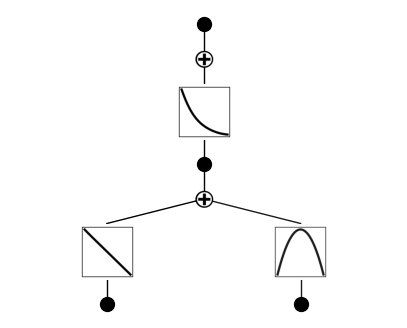

In [9]:
kan_model.plot()


saving model version 0.2


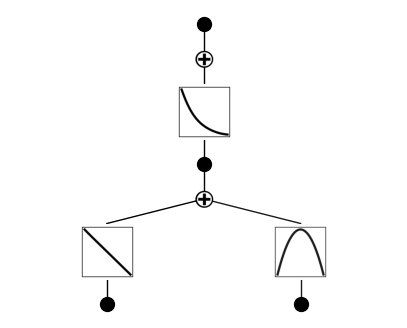

In [10]:
kan_model = kan_model.prune()
kan_model.plot()